<a href="https://colab.research.google.com/github/TheSeems/HseNotebooks/blob/main/Akhundov_algebra_15_2021_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import sympy
from sympy import Expr, Eq, latex, plot_implicit, tan, cot
from sympy.core import S, pi, sympify
from sympy.core.logic import fuzzy_bool
from sympy.core.numbers import Rational, oo
from sympy.core.compatibility import ordered
from sympy.core.symbol import Dummy, _uniquely_named_symbol, _symbol
from sympy.simplify import simplify, trigsimp
from sympy.functions.elementary.miscellaneous import sqrt, Max
from sympy.functions.elementary.trigonometric import cos, sin
from sympy.functions.special.elliptic_integrals import elliptic_e
from sympy.geometry.exceptions import GeometryError
from sympy.geometry.line import Ray2D, Segment2D, Line2D, LinearEntity3D
from sympy.polys import DomainError, Poly, PolynomialError
from sympy.polys.polyutils import _not_a_coeff, _nsort
from sympy.solvers import solve
from sympy.solvers.solveset import linear_coeffs
from sympy.utilities.misc import filldedent, func_name
from sympy.geometry.entity import GeometryEntity, GeometrySet
from sympy.geometry.point import Point, Point2D, Point3D
from sympy.geometry.line import Line, Segment
from sympy.geometry.util import idiff
import matplotlib.pyplot as plt
%matplotlib inline

# Занятие 15
# Алгебра
## Кривые второго порядка на плоскости: гипербола

In [14]:
class Hyperbola(GeometrySet):
    """
     Attributes
    ==========
    center
    hradius
    vradius
    eccentricity
    periapsis
    focus_distance
    foci
    ==========
    конструктор __new__
    скопирован из Эллипса,
    изменена формула для  hradius и vradius через эсцентриситет
    """
    def __new__(
        cls, center=None, hradius=None, vradius=None, eccentricity=None, **kwargs):
        hradius = sympify(hradius)
        vradius = sympify(vradius)

        eccentricity = sympify(eccentricity)

        if center is None:
            center = Point(0, 0)
        else:
            center = Point(center, dim=2)

        if len(center) != 2:
            raise ValueError('The center of "{0}" must be a two dimensional point'.format(cls))

        if len(list(filter(lambda x: x is not None, (hradius, vradius, eccentricity)))) != 2:
            raise ValueError(filldedent('''
                Exactly two arguments of "hradius", "vradius", and
                "eccentricity" must not be None.'''))

        if eccentricity is not None:
            if hradius is None:
                hradius = vradius/sqrt( eccentricity**2 - 1)
            elif vradius is None:
                vradius = hradius*sqrt( eccentricity**2 - 1)

        if hradius == 0:
            return "Line"
        if vradius == 0:
            return "Rays"
        return GeometryEntity.__new__(cls, center, hradius, vradius, **kwargs)
    
    @property
    def ambient_dimension(self):
        return 2
    
    @property
    def center(self):
        return self.args[0]

    @property
    def hradius(self):
        return self.args[1]
    
    @property
    def vradius(self):
        return self.args[2]
    @property
    def focus_distance(self):
        return sqrt(self.hradius**2 + self.vradius**2)
    
    @property
    def eccentricity(self):
        """The eccentricity of the ellipse."""
        return self.focus_distance/self.hradius
    
    @property
    def periapsis(self):
        """The apoapsis of the hyperbola.
        The smallest distance between the focus and the contour."""
        return self.focus_distance-self.hradius
    @property
    def foci(self):
        return (self.center + Point(-self.focus_distance, 0), self.center + Point(self.focus_distance, 0))
    
    @property
    def major(self):
        return self.hradius
    
    @property
    def minor(self):
        return self.vradius

    def asymptote(self, x='x', y='y', _angle=None, equation=False):
      x = _symbol(x, real=True)
      y = _symbol(y, real=True)

      dx = x - self.center.x
      a = self.hradius
      b = self.vradius

      if _angle is not None:
        k1 = (b + a * sympy.tan(_angle)) / (a - b * sympy.tan(_angle))
        k2 = (-b + a * sympy.tan(_angle)) / (a + b * sympy.tan(_angle))
        return wrap_to_eq(
            equation=equation,
            lhs=[y, y],
            rhs=[
                 self.center.y + k1 * dx,
                 self.center.y + k2 * dx
            ]
        )

      return wrap_to_eq(
          equation=equation,
          lhs=[y, y],
          rhs=[self.center.y + b / a * dx, self.center.y - b / a * dx]
      )

    def directrix(self, x='x', y='y', _angle=None, equation=False):
      x = _symbol(x, real=True)
      y = _symbol(y, real=True)
      a = self.hradius
      c = self.focus_distance

      if _angle is not None:
        dx = x - self.center.x
        return wrap_to_eq(
            equation=equation,
            lhs=[y, y],
            rhs=[
                 self.center.y - sympy.cot(_angle)*dx + a**2/c * sympy.sqrt(1 + sympy.cot(_angle)),
                 self.center.y - sympy.cot(_angle)*dx - a**2/c * sympy.sqrt(1 + sympy.cot(_angle))
            ]
        )

      return wrap_to_eq(
          equation=equation,
          lhs=[x, x],
          rhs=[self.center.x + a**2 / c, self.center.x - a**2 / c]
      )
      
    
    def equation(self, x='x', y='y', _slope=None, equation=False):
        """
        Returns the equation of a hyperbola aligned with the x and y axes;
        when slope is given, the equation returned corresponds to a hyperbola 
        with a major axis having that slope.
        Parameters
        ==========
        x : str, optional
            Label for the x-axis. Default value is 'x'.
        y : str, optional
            Label for the y-axis. Default value is 'y'.
        _slope : Expr, optional
                The slope of the major axis. Ignored when 'None'.
        Returns
        =======
        equation : sympy expression   """

        x = _symbol(x, real=True)
        y = _symbol(y, real=True)

        dx = x - self.center.x
        dy = y - self.center.y

        if _slope is not None:
            L = (dy - _slope*dx)**2
            l = (_slope*dy + dx)**2
            h = 1 + _slope**2
            a = h*self.major**2
            b = h*self.minor**2
            res= l/a - L/b 

        else:
            t1 = (dx/self.hradius)**2
            t2 = (dy/self.vradius)**2
            res = t1 - t2 
        if not equation:
            return res - 1
        else:
            return Eq(res, 1)       

In [15]:
from collections.abc import Iterable

def display_props(props):
  for title, value in props.items():
    print(title)

    if isinstance(value, Iterable):
      display(*value)
    else:
      display(value)

    print()

def display_hyperbola(hyperbola: Hyperbola, p = None, others=[], angles=[], show=True):
  if angles == []:
    angles = [0] * (len(others) + 1)

  hyp_eq = hyperbola.equation(x='x', y='y', _slope=sympy.tan(angles[0]))

  dict_free = {str(q): q for q in hyp_eq.free_symbols}

  if p:
    p.extend(plot_implicit(hyp_eq,
                    (dict_free['x'], -20, 20),
                    (dict_free['y'], -20, 20),
                    line_color='green',
                    label=sympy.latex(hyp_eq),
                    aspect_ratio=(1, 1), show=False, adaptive=False))
  else:
    p = plot_implicit(hyp_eq,
                    (dict_free['x'], -20, 20),
                    (dict_free['y'], -20, 20),
                    line_color='green',
                    aspect_ratio=(1, 1), show=False, adaptive=False)

  for ind, other in enumerate(others):
    other_eq = other.equation(x='x', y='y', _slope=sympy.tan(angles[ind + 1]))
    p.extend(plot_implicit(other_eq,
                           (dict_free['x'], -20, 20),
                           (dict_free['y'], -20, 20),
                           line_color='red',
                           aspect_ratio=(1, 1), show=False, adaptive=False))
  
  if show:
    p.show()
  return p, dict_free

def wrap_to_eq(lhs, rhs, equation=False):
  if equation:
    return [sympy.Eq(lhs[i], rhs[i]) for i in range(len(lhs))]
  return [lhs[i] - rhs[i] for i in range(len(lhs))]

# Занятие 15
# Алгебра
### Задание 1.
Построить гиперболу с центром в точке А(1, 2), полуосями 12 и 5. Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis и уравнение гиперболы.

In [16]:
A = Point(1, 2)
hyp = Hyperbola(A, hradius=12, vradius=5)

display_props({
    'Эксцентриситент': hyp.eccentricity,
    'Фокусное расстояние': hyp.focus_distance,
    'Фокусы': hyp.foci,
    'Periapsis': hyp.periapsis,
    'Уравнение': hyp.equation()
})

Эксцентриситент


13/12


Фокусное расстояние


13


Фокусы


Point2D(-12, 2)

Point2D(14, 2)


Periapsis


1


Уравнение


(x/12 - 1/12)**2 - (y/5 - 2/5)**2 - 1

### Задание 2.
Добавить в описание класса гипербол методы 

asymptote(self, x='x', y='y', equation=False)

directrix(self, x='x', equation=False)

Для гиперболы Задания 1 вывести на экран уравнения асимптот и директрис.

In [17]:
display_props({
    'Ассимптоты': hyp.asymptote(equation=True),
    'Директрисы': hyp.directrix(equation=True)
})

Ассимптоты


Eq(y, 5*x/12 + 19/12)

Eq(y, 29/12 - 5*x/12)


Директрисы


Eq(x, 157/13)

Eq(x, -131/13)

### Задание 3.
Вывести на экран уравнение гиперболы из задания 1 с поворотом на 30 градусов против часовой стрелки относительно ее центра.
Изобразить повернутую гиперболу с помощью plot_implicit.

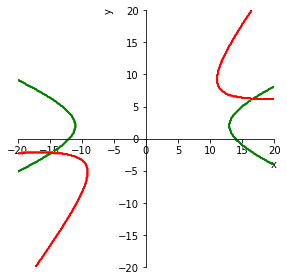

(<sympy.plotting.plot.Plot at 0x7faf6cbbd510>, {'x': x, 'y': y})

In [18]:
display_hyperbola(hyp, others=[hyp], angles=[0, sympy.pi / 6])

## Уравнения директрис и асимптот при повороте на угол $\alpha$
Пусть  $a$ - горизонтальная полуось, $c$ - фокусное расстояние, $x_0$ - горизонтальная координата центра гиперболы, тогда уравнение директрис 
$$
x = x_0 \pm \frac{a^2}{c}
$$
При повороте на угол $\alpha$ получается уравнение
$$
y = y_0 -{\rm ctg} \alpha(x - x_0) \pm \frac{a^2}{c}\sqrt{1 + {\rm ctg} \alpha}
$$
Уравнение асимптоты
$$
y = y_0 \pm \frac{b}{a}(x - x_0)
$$
При повороте на угол $\alpha$ получаются уравнения
\begin{align*}
y_1 = y_0 + k_1(x - x_0), \quad 
y_2 = y_0 + k_2(x - x_0), \\ 
k_1 = \frac{b + a{\rm tg} \alpha}{a - b{\rm tg} \alpha},\quad 
k_2 = \frac{-b + a{\rm tg} \alpha}{a + b{\rm tg} \alpha}
\end{align*}
### Задание 4.
Изобразить гиперболу Задания 3 (т.е. повернутую на угол) и ее асимптоты и директрисы на одном графике plot_implicit.

Eq(x*(-169*sqrt(3)/407 - 240/407) + y, 574/407 - 169*sqrt(3)/407)

Eq(x*(240/407 - 169*sqrt(3)/407) + y, 1054/407 - 169*sqrt(3)/407)

Eq(sqrt(3)*x + y, sqrt(3) + 2 + 144*sqrt(1 + sqrt(3))/13)

Eq(sqrt(3)*x + y, -144*sqrt(1 + sqrt(3))/13 + sqrt(3) + 2)

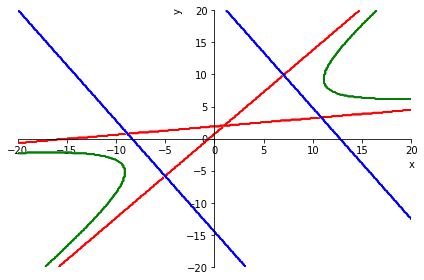

In [19]:
from sympy.plotting.plot import Plot

alpha = sympy.pi / 6

plotting = Plot(xlabel='x', ylabel='y')
plotting, dict_free = display_hyperbola(hyp, p = plotting, angles=[alpha], show=False)

asymps = hyp.asymptote(_angle = alpha, equation=True, x=dict_free['x'], y=dict_free['y'])
directx = hyp.directrix(_angle = alpha, equation=True, x=dict_free['x'], y=dict_free['y'])

a = hyp.hradius
b = hyp.vradius
c = hyp.focus_distance

display(*list(map(sympy.simplify, asymps)))
display(*list(map(sympy.simplify, directx)))
for a in asymps:
  plotting.extend(plot_implicit(sympy.simplify(a),
                    (dict_free['x'], -20, 20),
                    (dict_free['y'], -20, 20),
                    line_color='red',
                    aspect_ratio=(1, 1), show=False, adaptive=False))
for a in directx:
  plotting.extend(plot_implicit(sympy.simplify(a),
                    (dict_free['x'], -20, 20),
                    (dict_free['y'], -20, 20),
                    line_color='blue',
                    aspect_ratio=(1, 1), show=False, adaptive=False))

plotting.show()

###  Индивидуальное задание
Определить гиперболу с центром в точке $O$, полуосями $a$ и $b$.  Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis, уравнение гиперболы, уравнения асимптот и директрис. 

Изобразить гиперболу, повернутую на $\alpha$ градусов против часовой стрелки относительно ее центра, соответствующие асимптоты и директрисы. Вывести на экран уравнения повернутой гиперболы, соответствующих асимптот и директрис.

Эксцентриситент


sqrt(5)/2


Фокусное расстояние


3*sqrt(5)


Фокусы


Point2D(3 - 3*sqrt(5), 3)

Point2D(3 + 3*sqrt(5), 3)


Periapsis


-6 + 3*sqrt(5)


Уравнение


(x/6 - 1/2)**2 - (y/3 - 1)**2 - 1


Ассимптоты


-x/2 + y - 3/2

x/2 + y - 9/2


Директрисы


x - 12*sqrt(5)/5 - 3

x - 3 + 12*sqrt(5)/5


График повернутой гиперболы


Eq(x*(-5*sqrt(3) - 8) + y, -15*sqrt(3) - 21)

Eq(x*(8 - 5*sqrt(3)) + y, 27 - 15*sqrt(3))

Eq(sqrt(3)*x/3 + y, sqrt(3) + 3 + 4*sqrt(15*sqrt(3) + 45)/5)

Eq(sqrt(3)*x/3 + y, -4*sqrt(15*sqrt(3) + 45)/5 + sqrt(3) + 3)

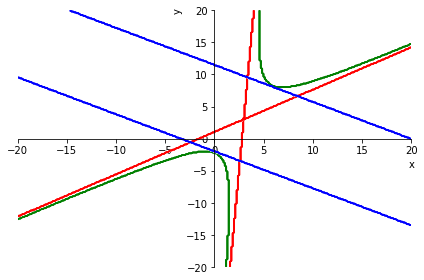

Уравнение


Eq((x + sqrt(3)*(y - 3) - 3)**2/144 - (y - sqrt(3)*(x - 3) - 3)**2/36, 1)


Ассимптоты


Eq(y, (3 + 6*sqrt(3))*(x - 3)/(6 - 3*sqrt(3)) + 3)

Eq(y, (-3 + 6*sqrt(3))*(x - 3)/(3*sqrt(3) + 6) + 3)


Директрисы


Eq(y, -sqrt(3)*(x - 3)/3 + 3 + 12*sqrt(5)*sqrt(sqrt(3)/3 + 1)/5)

Eq(y, -sqrt(3)*(x - 3)/3 - 12*sqrt(5)*sqrt(sqrt(3)/3 + 1)/5 + 3)

In [21]:
O = Point(3, 3)
a = 6
b = 3
alpha = sympy.pi / 3

hyp = Hyperbola(O, hradius=a, vradius=b)
display_props({
    'Эксцентриситент': hyp.eccentricity,
    'Фокусное расстояние': hyp.focus_distance,
    'Фокусы': hyp.foci,
    'Periapsis': hyp.periapsis,
    'Уравнение': hyp.equation(),
    'Ассимптоты': hyp.asymptote(),
    'Директрисы': hyp.directrix()
})

print('График повернутой гиперболы')

plotting = Plot(xlabel='x', ylabel='y')
plotting, dict_free = display_hyperbola(hyp, p = plotting, angles=[alpha], show=False)

asymps = hyp.asymptote(_angle = alpha, equation=True, x=dict_free['x'], y=dict_free['y'])
directx = hyp.directrix(_angle = alpha, equation=True, x=dict_free['x'], y=dict_free['y'])

a = hyp.hradius
b = hyp.vradius
c = hyp.focus_distance

display(*list(map(sympy.simplify, asymps)))
display(*list(map(sympy.simplify, directx)))
for a in asymps:
  plotting.extend(plot_implicit(sympy.simplify(a),
                    (dict_free['x'], -20, 20),
                    (dict_free['y'], -20, 20),
                    line_color='red',
                    aspect_ratio=(1, 1), show=False, adaptive=False))
for a in directx:
  plotting.extend(plot_implicit(sympy.simplify(a),
                    (dict_free['x'], -20, 20),
                    (dict_free['y'], -20, 20),
                    line_color='blue',
                    aspect_ratio=(1, 1), show=False, adaptive=False))

plotting.show()

display_props({
    'Уравнение': hyp.equation(_slope=sympy.tan(alpha), equation=True),
    'Ассимптоты': asymps,
    'Директрисы': directx
})